In [37]:
%pylab inline
import numpy as np
import scipy as sc
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import scipy.stats as ss
from scipy import sparse

from ABC_algorithm import ABC 
from ABC_algorithm import ABC 

#from post_adjusting_GK_corrected import PostProcessGK
#from post_adjusting_GK_corrected import EpanechnikovKernel

import statsmodels as sm
from sklearn.linear_model import LinearRegression


Populating the interactive namespace from numpy and matplotlib


In [38]:
def EpanechnikovKernel(t,delta,c=1):
    if t<=delta:
        return c*(1/delta)*(1-(t/delta)**2)
    else:
        return 0
def PostProcessGK(df, Summary, data, name_param = 'param1', q=0.5,  weighted=True):
    df_accepted = df[df['accept'] == 1]
    #print df_accepted.head
    accepted_count = len(df_accepted.index)
    #print accepted_count
    #print shape(data)[0]
    if accepted_count <= shape(data)[0]:
        print accepted_count, "is number of accepted thetas"

    if accepted_count < 2:
        print "Post processing failed; too few accepted values."

    summary = GKSummary(data)

    #print df_accepted.statistics
    #print Summary

    df_accepted.statistics_diff = df_accepted.statistics.apply(lambda x: np.subtract(x,summary))
    #print df_accepted.statistics_diff
    df_accepted.statistics_diff_abs = df_accepted.statistics_diff.apply(lambda x: np.power(np.sum(np.square(x)),0.5))
    #print df_accepted.statistics_diff_abs.shape
    #df_accepted.statistics_diff_abs.hist(bins=100)
    quantile = df_accepted.statistics_diff_abs.quantile(0.5) # shouled be ok
    #plt.show()
    #create column with kernal transform
    df_accepted.kernel = df_accepted.statistics_diff_abs.apply(lambda x: EpanechnikovKernel(x, delta=quantile)) #diff_abs

    mod = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
    #print type(df_accepted.statistics_diff)
    #X = np.array(df_accepted.statistics_diff) #list of vector

    #Create X
    size = shape(data)[0] #find a clever way to compute this!!!
    X = np.empty([accepted_count, size])
    i = 0
    for row in df_accepted.statistics_diff:
        X[i,] = row
        i += 1

    #print X
    #print type(X)
    #print shape(X)  
    #X = df_accepted.statistics_diff.as_matrix()
    #X.shape = (shape(X)[0], len(data))  
    #X = np.reshape(X, (shape(X)[0], 100))
    # df.reset_index().values
    y = np.array(df_accepted[name_param])
    y.shape = (shape(y)[0],1)
    #print shape(y)eemilka
    
    #print type(y)
    #print y
    weights = np.array(df_accepted.kernel)
    if weighted:
        res = mod.fit(X, y, sample_weight=weights)
    else: 
        res = mod.fit(X, y)
        
    beta = res.coef_[0]
   
    beta.shape = (shape(beta)[0], 1)
   
    
    part_res = np.matmul(X, beta)
    #print shape(part_res)
    #print shape(y)
    res = np.subtract(y, part_res)
    return res

In [39]:
def SimulateGK(n, param):  #B>0, K>-1/2 #param is a vector of A, B, g, k
    A, B, g, k = param[0], param[1], param[2], param[3]
    u_values = np.random.uniform(low=0.0, high=1.0, size=n)
    x_values = np.zeros(n)
    for i in range(0,n):
        x_values[i] = A + B*(1+0.8*(1-np.exp(-g*sc.stats.norm.ppf(u_values[i], 0, 1) )) /(1 + np.exp(-g*sc.stats.norm.ppf(u_values[i], 0, 1) ))) *np.power((1+ np.power(sc.stats.norm.ppf(u_values[i], 0, 1),2)),k)*(sc.stats.norm.ppf(u_values[i], 0, 1))    
    return x_values


param = [3,1,2,0.5]
data = SimulateGK(10, param) # only 10 datapoints

def GKPriorSampler(n): 
    l = []
    for i in range(n):
        l.append(np.random.uniform(low=0.0, high=10.0, size=4)) # we assume uniform [1,10] prior for all 4 parameters
    return l

def GKLiklihoodSimulator(n, param):
    #unknown mean
    return SimulateGK(n, param)
    
def GKSummary(data):
    return np.sort(data)  #The summary statistic is the identity function. No transformation on the data. 


In [40]:
epsilon_count = 2
epsilon = 900
epsilon_increment = 400

k = 5
n = 10000

def calc_error(dist_from_truth, abc_post_means, epsilon, error_epsilon_list):
    #print dist_from_truth
    squared_dist_from_truth = np.power(dist_from_truth,2)
    mse = np.mean(squared_dist_from_truth)
    mse_err = 1.96*np.std(squared_dist_from_truth)

    mc_bias = np.mean(dist_from_truth)
    mc_bias_err = 1.96*np.std(dist_from_truth)

    var = np.var(abc_post_means)

    mse_check = np.add(var, np.power(mc_bias,2))

    error_epsilon_list.append({'epsilon':epsilon,
                               'bias':mc_bias, 'bias_err':mc_bias_err, 
                               'mse':mse, 'mse_err':mse_err,
                               'var':var,
                               'mse_check':mse_check
                              })
    return error_epsilon_list

## Calculating MSE for different values of $\epsilon$

In [41]:
# for param1
post_mean = 3
error_epsilon_list = []
pp_error_epsilon_list = []

for e in range(epsilon_count):
    epsilon = epsilon + epsilon_increment
    
    #print "epsilon:{}".format(epsilon)

    abc_post_means = []
    pp_abc_post_means = []
    dist_from_truth = []
    pp_dist_from_truth = []

    for i in range(k):
        ## we will do abc k times for each epsilon
        # print "Iteration:{}".format(i)
        df_ei = ABC(GKPriorSampler, GKLiklihoodSimulator,GKSummary, epsilon, data, n)
    
        df_ei['param1'] = df_ei['theta'].apply(lambda x: x[0]) #selecting the FIRST parameter of the par list (A) 
                                                 #and assigning it to a new col of df
        df_ei['param2'] = df_ei['theta'].apply(lambda x: x[1]) #selecting the SECOND parameter of the par list (B) 
                                                 #and assigning it to a new col of df
        df_ei['param3'] = df_ei['theta'].apply(lambda x: x[2]) #selecting the SECOND parameter of the par list (G) 
                                                 #and assigning it to a new col of df
        df_ei['param4'] = df_ei['theta'].apply(lambda x: x[3]) #selecting the SECOND parameter of the par list (k) 
                                             
    
        df_abc_accepted = df_ei[df_ei.accept == 1]
        count_accepted = len(df_abc_accepted.index)
        #print count_accepted
        if count_accepted < 20:
            #print "Not doing post adjustment"
            pp_abc_post_means.append(np.nan)
            pp_dist_from_truth.append(np.nan)
        else:
            ## also post process the ABC output
            
            df_abc_accepted_post_processed = PostProcessGK(df_ei, GKSummary, data, name_param = 'param1', weighted=True)
            #df_abc_accepted_post_processed = df_ei
            pp_abc_post_mean = df_abc_accepted_post_processed.mean()
            pp_abc_post_means.append(pp_abc_post_mean)
            print "post mean", pp_abc_post_mean
            pp_dist_from_truth.append(abs(pp_abc_post_mean - post_mean))

            ## store k abc posterior means w and w/out post processing (pp)
        abc_post_mean = df_abc_accepted.param1.mean()
        abc_post_means.append(abc_post_mean)
        print "without_post_mean", abc_post_mean
        ## and store dist of this from truth
        dist_from_truth.append(abs(abc_post_mean - post_mean))
        
    error_epsilon_list = calc_error(dist_from_truth, abc_post_means, epsilon, error_epsilon_list)
    pp_error_epsilon_list = calc_error(pp_dist_from_truth, pp_abc_post_means, epsilon, pp_error_epsilon_list)

    
mse_df = pd.DataFrame(error_epsilon_list)
pp_mse_df = pd.DataFrame(pp_error_epsilon_list)

post mean 1.8372297268
without_post_mean 4.99536847988
post mean 1.8996642802
without_post_mean 5.08789424246
post mean 2.0892033485
without_post_mean 5.07089182151
post mean 2.0550718389
without_post_mean 4.96249658047
post mean 1.99443172837
without_post_mean 5.04846547469
post mean 2.45795645674
without_post_mean 4.99574839147
post mean 1.86098395534
without_post_mean 4.95573966465
post mean 1.77791196984
without_post_mean 4.96758670484
post mean 1.81466480801
without_post_mean 4.9784016235
post mean 1.55736594605
without_post_mean 4.89611090955


In [42]:
print mse_df.head()
print pp_mse_df.head()

       bias  bias_err  epsilon       mse  mse_check   mse_err       var
0  2.033023  0.092246     1300  4.135399   4.135399  0.373579  0.002215
1  1.958717  0.066558     1700  3.837727   3.837727  0.258595  0.001153
       bias  bias_err  epsilon       mse  mse_check   mse_err       var
0  1.024880  0.184880     1300  1.059276   1.059276  0.383501  0.008898
1  1.106223  0.589455     1700  1.314176   1.314176  1.132789  0.090446


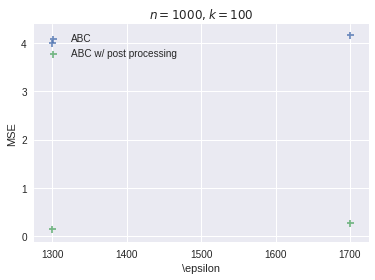

In [22]:
sns.regplot(x=mse_df.epsilon, y=mse_df.mse, marker="+", fit_reg=False, label='ABC')
sns.regplot(x=pp_mse_df.epsilon, y=pp_mse_df.mse, marker="+", fit_reg=False, label='ABC w/ post processing')
#plt.errorbar(x=mse_df.epsilon, y=mse_df.mse, yerr=mse_df.mse_err, linestyle="None")
plt.xlabel(r'\epsilon')
plt.ylabel(r'MSE')
plt.title(r'$n=1000, k=100$')
plt.legend(loc='upper left')
#plt.savefig('plots/gk_mse_epsilon.pdf')